# Import libraries

In [ ]:
import numpy as np
import pandas as pd 
from tqdm import tqdm
import math
import time
import seaborn as sns
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import AdaBoostClassifier

tqdm.pandas()

# Reading data

In [3]:
train = pd.read_csv('data_set/train.csv')
test = pd.read_csv('data_set/test.csv')
sample_submission = pd.read_csv('data_set/sample_submission.csv')

- `order_id` : unique id for each order
- `order_time`: time of the creation of order by the client
- `order_date` : date of the order
- `allot_time`: time of allocation of order to the rider
- `accept_time`: time of acceptance of the order by the rider (if available)
- `pickup_time`: time of pickup of the order (if available)
- `delivered_time`: time of delivery of the order (if available)
- `cancelled_time`: time of cancellation of order (if the order was cancelled)
- `cancelled`: whether the order was cancelled
- `rider_id`: unique id for each rider
- `first_mile_distance`: road distance from rider’s location to the pickup location
- `last_mile_distance`: road distance from pickup location to the delivery location
- `allotted_orders`: total number of orders allotted to the rider in the 30 days before (not including) order_date
- `delivered_orders`: total number of orders delivered by the rider in the 30 days before (not including) order_date
- `undelivered_orders`: total number of orders allotted to but not delivered by the rider (i.e. cancelled) in the 30 days before (not including) order_date
- `lifetime_order_count`: total number of orders delivered by the rider at any time before order_date
- `reassigned_order`: whether the order was reassigned to this rider
- `reassignment_method`: if the order was reassigned, whether the reassignment was done manually (by the ops team) or automatically
- `reassignment_reason`: a more detailed reason for the reassignment
- `session_time`: total time the rider had been online on order_date before order_time


In [4]:
id_columns = ['order_id']

time_columns = ['order_time', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time','cancelled_time']

categorical_columns = ['reassignment_method','reassignment_reason']

# Converting to datetime and object

In [ ]:
ids = train[id_columns]
train = train.drop(ids, axis=1)
test = test.drop(ids,axis=1)

for col in time_columns:
    train[col] = pd.to_datetime(train[col])
    try:
        test[col] = pd.to_datetime(test[col])
    except:
        continue

for col in categorical_columns:
    train[col] = train[col].astype('object')
    try:
        test[col] = test[col].astype('object')
    except:
        continue

# Preprocessing

In [6]:
def peak_hour(x):
    if x>=8 and x<=11:
        return 1
    if x>=13 and x<=19:
        return 1
    return 0

def log_normal(x):
    if x==0:
        return 0
    if x>0:
        return math.log(x)
    else:
        return math.log(abs(x))

In [7]:
def preprocess(df):
    df['order_day'] = df['order_date'].dt.dayofyear
    df['diff_allot_order'] = df['allot_time']-df['order_time']
    df['diff_allot_order'] = df['diff_allot_order'].dt.components['hours']*3600+df['diff_allot_order'].dt.components['minutes']*60+df['diff_allot_order'].dt.components['seconds']
    df['diff_accept_allot'] = df['accept_time']-df['allot_time']
    df['diff_accept_allot'] = df['diff_accept_allot'].dt.components['hours']*3600+df['diff_accept_allot'].dt.components['minutes']*60+df['diff_accept_allot'].dt.components['seconds']
    df['diff_accept_order'] = df['accept_time']-df['order_time']
    df['diff_accept_order'] = df['diff_accept_order'].dt.components['hours']*3600+df['diff_accept_order'].dt.components['minutes']*60+df['diff_accept_order'].dt.components['seconds']
    df['total_dist'] = df['first_mile_distance']+df['last_mile_distance']
    df['hour_in_day'] = df['order_time'].dt.hour
    df['day_of_week'] = df['order_date'].dt.dayofweek
    df[['cum_diff_allot_order','cum_diff_accept_allot','cum_diff_accept_order','cum_total_dist','cum_first_mile_dist','cum_last_mile_dist']]=df.groupby(['rider_id','order_date'])[['diff_allot_order','diff_accept_allot','diff_accept_order','total_dist','first_mile_distance','last_mile_distance']].cumsum()
    df['order_today'] = df.groupby(['rider_id','order_date']).cumcount()
    df['orders_cum'] = df.groupby(['rider_id']).cumcount()
    df['reassigned_order'] = df['reassigned_order'].fillna(0)                                                      
    df['saturday'] = df['day_of_week'].apply(lambda x:1 if x==5 else 0)
    for col in df.columns:
        if df[col].isnull().sum()>0:
            df[col]=df[col].fillna(0)
    df['orders_diff'] = df['alloted_orders']-df['delivered_orders']
    riders = df.groupby(['order_date','hour_in_day'])['rider_id'].count().to_dict()
    df['riders_available'] = df.apply(lambda x: riders[(x.order_date,x.hour_in_day)],axis=1)
    df['reliability'] = (df['alloted_orders']-df['undelivered_orders'])*100/df['alloted_orders']
    df['reliability'] = df['reliability'].fillna(0)
    cols = []
    col_dict = ((df.dtypes==int)|(df.dtypes==float)).to_dict()
    for col in col_dict.keys():
        if col_dict[col]:
            cols.append(col)
    df["mean"] = df[cols].mean(axis=1)
    df["std"] = df[cols].std(axis=1)
    df["min"] = df[cols].min(axis=1)
    df["max"] = df[cols].max(axis=1) 
    
    return df

# Train Valid Split

In [ ]:
train_df = train[:395778]
valid_df = train[395778:]
train_df = preprocess(train_df)
valid_data = preprocess(valid_df)
test_df= preprocess(test)

# Rider details feature engineering

In [ ]:
rider_cols_mean = ['session_time', 'first_mile_distance','last_mile_distance','total_dist']

df = pd.concat([train_df,valid_df,test_df])

data = df.groupby('rider_id').cumsum()[rider_cols_mean]
data['cumcounts'] = df.groupby('rider_id').cumcount()
data['cumcounts'] = data['cumcounts']+1
for i in ['session_time', 'first_mile_distance', 'last_mile_distance', 'total_dist']:
    data[i] = data[[i,'cumcounts']].progress_apply(lambda x:x[i]/x['cumcounts'],axis=1)

In [ ]:
rider_deets = data.copy()
rider_deets

,session_time,first_mile_distance,last_mile_distance,total_dist,cumcounts
0,0.000000,1.566600,2.650000,4.216600,1
1,3.266667,2.520700,2.760000,5.280700,1
2,9.816667,2.207400,4.800000,7.007400,1
3,17.533333,2.189400,6.380000,8.569400,1
4,1.350000,2.787000,4.010000,6.797000,1
...,...,...,...,...,...
144839,137.422523,1.766382,2.750000,4.516382,37
144840,411.332222,0.460262,1.067333,1.527595,30
144841,121.676190,0.996990,2.565571,3.562562,70
144842,456.847764,1.200194,2.513780,3.713974,82


In [ ]:
time_columns = ['order_time', 'order_date', 'allot_time', 'accept_time',
       'pickup_time', 'delivered_time','cancelled_time']
numerical_columns = ['first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders', 'lifetime_order_count',
                    'session_time','diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist','cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order', 'cum_total_dist', 'allotted_orders',
                     'riders_available','orders_cum','reliability']
categorical_columns = ['reassignment_method','reassignment_reason','reassigned_order','order_day','hour_in_day','undelivered_orders','day_of_week',
                       'order_today', 'allotted', 'deliveries','period_in_day','saturday','first_mile', 'last_mile','orders_diff']

In [ ]:
train_df_c = train_df[train_df['cancelled']==1].sample(int(train_df[train_df['cancelled']==1].shape[0]*1),replace=False,random_state=42)
train_df_d = train_df[train_df['cancelled']==0].sample(int(train_df_c.shape[0])*1,random_state=42)

In [ ]:
combined_df = pd.concat([train_df_c,train_df_d])
combined_df = combined_df.sort_values('order_time')

In [ ]:
cols = ['first_mile_distance',
       'last_mile_distance', 'alloted_orders', 'delivered_orders',
       'undelivered_orders', 'lifetime_order_count',
       'session_time',
       'order_day', 'diff_allot_order', 'diff_accept_allot',
       'diff_accept_order', 'total_dist', 'hour_in_day', 'day_of_week','cum_diff_allot_order', 'cum_diff_accept_allot',
       'cum_diff_accept_order','reassigned_order',
       'cum_total_dist', 'order_today','rider_id','orders_cum',
       'saturday','orders_diff','riders_available','cum_first_mile_dist','cum_last_mile_dist','reliability','mean','std','min','max']


# Combining datasets with details about the rider

In [ ]:
combined_df = combined_df[cols+['cancelled']]
combined_df = pd.merge(combined_df,rider_deets[:-test_df.shape[0]],left_index=True,right_index=True)

X_train = combined_df.drop('cancelled',axis=1)
y_train = combined_df['cancelled']


valid_df = valid_data[cols+['cancelled']]
valid_df = pd.merge(valid_df,rider_deets[:-test_df.shape[0]],left_index=True,right_index=True)

X_test = valid_df.drop('cancelled',axis=1)
y_test = valid_df['cancelled']

# Predictions
### All model hyperparameters were tuned using XGBoost Optuna or GridSearch

# Random Forests Classifier

In [ ]:
params = {'n_estimators': 900, 'max_depth': 40, 'random_state': 2020, 'min_samples_split': 10, 'min_samples_leaf': 2}

rf = RandomForestClassifier(**params)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=40, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=900, random_state=2020)

In [ ]:
rf_preds = rf.predict(X_test)
rf_preds_prob = rf.predict_proba(X_test)[:,1]

              precision    recall  f1-score   support

           0       0.99      0.86      0.92     53618
           1       0.04      0.53      0.07       604

    accuracy                           0.85     54222
   macro avg       0.52      0.70      0.50     54222
weighted avg       0.98      0.85      0.91     54222

Test Accuracy:  0.8519973442514108
Train Accuracy:  0.9843953185955787
AUC Score: 0.7415215780803076


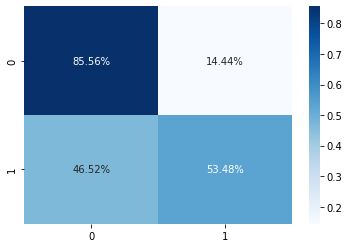

In [ ]:
result = confusion_matrix(y_test, rf_preds)
r = np.sum(result,axis=1)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
print(classification_report(y_test,rf_preds))
print('Test Accuracy: ',rf.score(X_test,y_test))
print('Train Accuracy: ',rf.score(X_train,y_train))
print('AUC Score:',roc_auc_score(y_test,rf_preds_prob))

# XGBoost Classifier

In [ ]:
params = {'lambda': 0.20177241158844367, 'alpha': 3.4670054832209787, 'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.02, 'max_depth': 5, 'random_state': 48, 'min_child_weight': 37}

xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train,eval_metric='auc')
xgby_pred = xgb_model.predict(X_test)
xgby_preds_prob = xgb_model.predict_proba(X_test)[:,1]

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Classification Report:
Train Accuracy:  0.7109882964889467
Test Accuracy: 0.8759544096492199
AUC Score: 0.7360545713495938


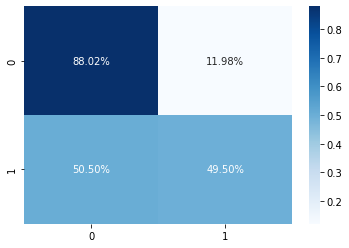

In [ ]:
result = confusion_matrix(y_test, xgby_pred)
r = np.sum(result,axis=1)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
result1 = classification_report(y_test, xgby_pred)
print("Classification Report:",)
result2 = accuracy_score(y_test,xgby_pred)
print('Train Accuracy: ',xgb_model.score(X_train,y_train))
print("Test Accuracy:",result2)
print('AUC Score:',roc_auc_score(y_test,xgby_preds_prob))

# AdaBoost Classifier

              precision    recall  f1-score   support

           0       0.99      0.81      0.89     53618
           1       0.03      0.57      0.06       604

    accuracy                           0.81     54222
   macro avg       0.51      0.69      0.48     54222
weighted avg       0.98      0.81      0.89     54222

Train Accuracy:  0.7196575639358475
Test Accuracy:  0.8109623400095902
AUC Score: 0.7421973945440383


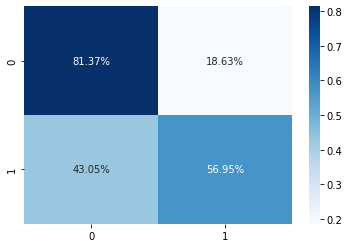

In [ ]:
abclassifier = AdaBoostClassifier(n_estimators=1000,learning_rate=0.1)
abclassifier.fit(X_train, y_train)
aby_pred = abclassifier.predict(X_test)
aby_preds_prob = abclassifier.predict_proba(X_test)[:,1]
result = confusion_matrix(y_test, aby_pred)
r = np.sum(result,axis=1)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
print(classification_report(y_test, aby_pred))

print('Train Accuracy: ',abclassifier.score(X_train,y_train))
print('Test Accuracy: ',abclassifier.score(X_test,y_test))

print('AUC Score:',roc_auc_score(y_test,aby_preds_prob))

# Checking ensemble results for validation data

[[46331  7287]
 [  282   322]]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     53618
           1       0.04      0.53      0.08       604

    accuracy                           0.86     54222
   macro avg       0.52      0.70      0.50     54222
weighted avg       0.98      0.86      0.92     54222

AUC Score:  0.7432780246526879


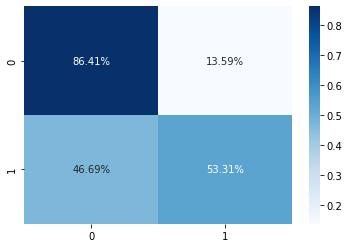

In [ ]:
check = pd.DataFrame()
check['rf_pred'] = rf_preds_prob
check['xgb_pred'] = xgby_preds_prob
check['knn_pred'] = knny_preds_prob
check['ada_pred'] = aby_preds_prob
check['sums'] = check[['rf_pred','xgb_pred','ada_pred']].mean(axis=1)
check['cancelled'] = y_test.reset_index()['cancelled']
check['pred'] = check['sums'].apply(lambda x: 1 if x>=0.5 else 0)
result = confusion_matrix(y_test, check['pred'])
print(result)
a,b,c,d=result[0][0]/r[0],result[0][1]/r[0],result[1][0]/r[1],result[1][1]/r[1]
sns.heatmap([[a,b],[c,d]], annot=True, fmt=".2%", cmap='Blues')
print(classification_report(y_test, check['pred']))
print("AUC Score: ",roc_auc_score(y_test,check['sums']))

# Predicting on test data and submission

In [ ]:
test_df = test_df[cols]
test_data = pd.merge(test_df,rider_deets[rider_deets.shape[0]//2:],left_index=True,right_index=True)

In [ ]:
y_preds_rf = rf.predict_proba(test_data)[:,1]
y_preds_xgb = xgb_model.predict_proba(test_data)[:,1]
y_preds_ada = abclassifier.predict_proba(test_data)[:,1]
y_preds_knn = classifier.predict_proba(test_data)[:,1]

In [ ]:
sub = pd.DataFrame(columns = ['order_id'])
sub['order_id'] = pd.read_csv('../input/cascade-cup-22/test.csv')['order_id']
sub['rf_pred'] = y_preds_rf
sub['xgb_pred'] = y_preds_xgb
sub['ada_pred'] = y_preds_ada
sub['knn_pred'] = y_preds_knn
sub['sums'] = sub[['rf_pred','xgb_pred','ada_pred']].mean(axis=1)
sub['cancelled'] = sub['sums'].apply(lambda x: x)
sub

,order_id,rf_pred,lgb_pred,xgb_pred,ada_pred,knn_pred,cat_pred,sums,cancelled
0,130231,0.326520,0.472883,0.394723,0.500141,0.310628,0.351581,0.357608,0.357608
1,130232,0.301476,0.477924,0.421332,0.499012,0.413232,0.138844,0.287217,0.287217
2,130233,0.311470,0.450105,0.352763,0.498999,0.244146,0.273005,0.312413,0.312413
3,130234,0.389478,0.463086,0.389463,0.499904,0.187050,0.374400,0.384447,0.384447
4,130235,0.332612,0.450253,0.339454,0.499133,0.324717,0.271001,0.314356,0.314356
...,...,...,...,...,...,...,...,...,...
144839,41184,0.364317,0.457743,0.389816,0.498787,0.414154,0.274086,0.342739,0.342739
144840,41185,0.349903,0.443502,0.344096,0.499903,0.326938,0.519332,0.404444,0.404444
144841,41186,0.372121,0.448354,0.366995,0.499008,0.221701,0.371994,0.370370,0.370370
144842,41187,0.493329,0.476625,0.382035,0.500958,0.512572,0.437195,0.437519,0.437519


In [ ]:
sub[['order_id','cancelled']].to_csv('submission.csv',index=False)